# 1. Data

## 1.1. Read Data

In [1]:
# Import the libraries 
import time
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, PillowWriter 
from collections import defaultdict
from queue import PriorityQueue

In [2]:
df = pd.read_csv("Distance.csv")
df.head()

,Province,Ho Chi Minh,Ha Noi,Hai Phong,Can Tho,Dong Nai,Quang Nam,Bac Ninh,Hai Duong,Nghe An,...,Ha Nam,Hung Yen,Kien Giang,Lai Chau,Da Nang,Dak Nong,Dien Bien,Vinh Phuc,Latitude,Longitude
0,Ho Chi Minh,0.000000,1160.328125,1116.327582,124.340009,30.558650,597.455091,1160.851404,1132.378709,885.694721,...,1094.960639,1124.167884,253.245571,1338.581425,612.139008,197.376884,1284.528508,1184.499927,10.7638,106.6436
1,Ha Noi,1160.328125,0.000000,126.385860,1235.554616,1144.991818,656.690777,59.499238,88.532125,274.868404,...,75.458333,61.937428,1253.715745,264.688208,632.876926,1012.092866,258.969150,25.156596,21.1382,105.5050
2,Hai Phong,1116.327582,126.385860,0.000000,1201.305114,1098.305041,575.045991,74.855725,38.212372,257.613414,...,81.046226,67.797153,1233.502621,388.365117,552.142680,954.684700,385.354979,131.855404,20.8000,106.6667
3,Can Tho,124.340009,1235.554616,1201.305114,0.000000,154.836491,706.318330,1240.919573,1214.553251,961.075782,...,1173.594679,1203.685561,141.402052,1397.101956,719.138646,318.316161,1340.060030,1260.217144,10.0333,105.7833
4,Dong Nai,30.558650,1144.991818,1098.305041,154.836491,0.000000,572.923473,1144.164266,1115.131849,870.755857,...,1078.756363,1107.678552,282.901262,1327.577244,588.201480,169.248401,1274.383073,1168.998580,10.9277,106.8681


## 1.2. Random Main Warehouse

In [ ]:
# Random mainwarehouse: mw_north, mw_central, mw_south
# Create list store province bound -> random
list_mw_north, list_mw_central, list_mw_south = [], [], []
for i in range(df.shape[0]):
    if df.iloc[i,64] > 20:
        list_mw_north.append(df.iloc[i,0])
    elif df.iloc[i,64] < 12:
        list_mw_south.append(df.iloc[i,0])
    else: 
        list_mw_central.append(df.iloc[i,0])

# Random
random.seed(100)
mw_north, mw_central, mw_south = random.choice(list_mw_north), random.choice(list_mw_central), random.choice(list_mw_south)
print(mw_north,mw_central,mw_south, sep = "\n")

## 1.3. Convert Distance -> Distance Truck -> Distance Plane (Main Warehouse)

In [ ]:
# Convert distance -> cost
# Cost truck = (Distance / 60) * 35
def distance_to_truck_cost(dis_truck):
    return (dis_truck * 35) / 60 
# apply to convert distance to cost truck 
df.iloc[:, 1:64] = df.iloc[:, 1:64].apply(distance_to_truck_cost)

In [ ]:
# Check data after convert distance to cost
df.head()

In [ ]:
# Find id mw
(id_north, id_central, id_south) = (0,0,0)

# Store name of each province (delete strip space)
Province_space = df['Province']  # maybe have space L/R
Province = []
for i in Province_space:
    Province.append(i.strip())
for index in range(len(Province)):
    if Province[index] == mw_north:
        id_north += index 
    elif Province[index] == mw_central:
        id_central += index 
    elif Province[index] == mw_south:
        id_south += index 

# Cost plane = (Distance / 80) * 160 = (120 * Distance_Truck) / 35
# North
df.iloc[id_north, id_central+1] = (df.iloc[id_north, id_central+1] * 120) / 35
df.iloc[id_north, id_south+1] = (df.iloc[id_north, id_south+1] * 120) / 35
# Central
df.iloc[id_central, id_north+1] = (df.iloc[id_central, id_north+1] * 120) / 35
df.iloc[id_central, id_south+1] = (df.iloc[id_central, id_south+1] * 120) / 35
# South
df.iloc[id_south, id_north+1] = (df.iloc[id_south, id_north+1] * 120) / 35
df.iloc[id_south, id_central+1] = (df.iloc[id_south, id_central+1] * 120) / 35

# Check convert data to cost
df.head()

# DO NOT USE TWICE

In [ ]:
# Save new file with convert to (truck, plane) cost
df.to_csv('Cost.csv', index = False)

##  1.4. Add Main Warehouse (cost) to Data Another Main Warehouse (3)

In [ ]:
def data_A_star(start,goal, mw_north, mw_central, mw_south):  
    # Data built in with Province 
    province_neighbor ={'Lai Chau':['Dien Bien','Lao Cai','Son La','Yen Bai'],
                'Yen Bai':['Lao Cai','Lai Chau','Son La','Ha Giang','Phu Tho','Tuyen Quang'],
                'Dien Bien':['Lai Chau','Son La'],
                'Thanh Hoa':['Son La','Nghe An','Ninh Binh','Hoa Binh'],
                'Nghe An':['Ha Tinh','Thanh Hoa'],
                'Quang Binh':['Ha Tinh','Quang Tri'] ,
                'Ha Tinh':['Nghe An','Quang Binh'],
                'Hue':['Quang Tri','Da Nang','Quang Nam'],
                'Quang Tri':['Quang Binh','Hue'],
                'Da Nang':['Hue','Quang Nam'],
                'Quang Nam':['Da Nang','Hue','Kon Tum','Quang Ngai'],
                'Kon Tum':['Quang Nam','Quang Ngai','Gia Lai'],
                'Quang Ngai':['Kon Tum','Quang Nam','Binh Dinh'],
                'Gia Lai':['Kon Tum','Binh Dinh','Phu Yen','Dak Lak'],
                'Binh Dinh':['Quang Ngai','Gia Lai','Phu Yen'],
                'Dak Lak':['Dak Nong','Lam Dong','Khanh Hoa','Phu Yen','Gia Lai'],
                'Phu Yen':['Gia Lai','Binh Dinh','Dak Lak','Khanh Hoa'],
                'Khanh Hoa':['Dak Lak','Phu Yen','Lam Dong','Ninh Thuan'],
                'Dak Nong':['Dak Lak','Lam Dong','Binh Phuoc'],
                'Lam Dong':['Dak Lak','Dak Nong','Binh Phuoc','Dong Nai','Binh Thuan','Ninh Thuan','Khanh Hoa'],
                'Ninh Thuan':['Lam Dong','Khanh Hoa','Binh Thuan'],
                'Binh Phuoc':['Tay Ninh','Binh Duong','Dong Nai','Dak Nong','Lam Dong'],
                'Dong Nai':['Lam Dong','Binh Phuoc','Binh Thuan','Ho Chi Minh','Vung Tau','Binh Duong'],
                'Binh Thuan':['Vung Tau','Lam Dong','Ninh Thuan','Dong Nai'],
                'Tay Ninh':['Long An', 'Ho Chi Minh', 'Binh Duong','Binh Phuoc'],
                'Binh Duong':['Tay Ninh','Ho Chi Minh','Dong Nai','Binh Phuoc'],
                'Ho Chi Minh':['Tay Ninh','Binh Duong','Dong Nai','Long An','Vung Tau'],
                'Vung Tau':['Ho Chi Minh','Dong Nai','Binh Thuan'],
                'Long An':['Tay Ninh','Ho Chi Minh','Dong Thap','Tien Giang'],
                'Dong Thap':['Long An','Tien Giang','Vinh Long','Can Tho','An Giang'],
                'Tien Giang':['Long An','Dong Thap','Vinh Long','Ben Tre'],
                'Ben Tre':['Vinh Long','Tien Giang','Tra Vinh'],
                'An Giang':['Kien Giang','Can Tho','Dong Thap'],
                'Can Tho':['Kien Giang','An Giang','Dong Thap','Vinh Long','Hau Giang'],
                'Vinh Long':['Can Tho','Dong Thap','Ben Tre','Tra Vinh','Hau Giang'],
                'Tra Vinh':['Ben Tre','Vinh Long','Soc Trang'],
                'Soc Trang':['Hau Giang','Bac Lieu','Tra Vinh'],
                'Hau Giang':[ 'Kien Giang','Bac Lieu','Soc Trang','Can Tho','Vinh Long'],
                'Kien Giang':['An Giang','Can Tho','Hau Giang','Bac Lieu','Ca Mau'],
                'Bac Lieu':['Kien Giang','Hau Giang','Soc Trang','Ca Mau'],
                'Ca Mau':['Kien Giang','Bac Lieu'],
                'Ha Noi':['Phu Tho','Hoa Binh','Bac Giang','Vinh Phuc','Bac Ninh','Hung Yen','Ha Nam'],
                'Phu Tho':['Son La','Yen Bai','Hoa Binh','Ha Noi','Vinh Phuc','Tuyen Quang'],
                'Hoa Binh':['Ninh Binh','Thanh Hoa','Ha Nam','Ha Noi','Phu Tho','Son La'],
                'Bac Giang':['Quang Ninh','Hai Duong','Bac Ninh','Ha Noi','Thai Nguyen','Lang Son'],
                'Vinh Phuc':['Phu Tho', 'Ha Noi','Thai Nguyen','Tuyen Quang'],
                'Bac Ninh':['Ha Noi','Hung Yen','Hai Duong', 'Bac Giang'],
                'Hung Yen':['Ha Noi','Bac Ninh','Hai Duong','Thai Binh','Ha Nam'],
                'Ha Nam':['Ha Noi','Hung Yen','Thai Binh','Nam Dinh','Ninh Binh','Hoa Binh'],
                'Hai Phong':['Thai Binh','Thai Binh','Quang Ninh'],
                'Hai Duong':['Bac Ninh', 'Hung Yen','Thai Binh','Hai Phong','Quang Ninh','Bac Giang'],
                'Nam Dinh':['Ninh Binh','Ha Nam','Thai Binh'],
                'Thai Nguyen':['Tuyen Quang', 'Bac Kan','Lang Son','Bac Giang','Ha Noi','Vinh Phuc'],
                'Thai Binh':['Nam Dinh', 'Ha Nam','Hung Yen','Hai Duong','Hai Duong','Hai Phong'],
                'Quang Ninh':['Hai Duong','Hai Phong','Bac Giang','Lang Son'],
                'Lang Son':['Quang Ninh','Bac Giang','Thai Nguyen','Bac Kan','Cao Bang'],
                'Ninh Binh':['Hoa Binh','Thanh Hoa','Nam Dinh','Ha Nam'],
                'Lao Cai':['Lai Chau','Yen Bai','Ha Giang'],
                'Cao Bang':['Ha Giang','Bac Kan','Lang Son'],
                'Ha Giang':['Cao Bang','Tuyen Quang','Yen Bai','Lao Cai'],
                'Tuyen Quang':['Ha Giang','Bac Kan','Thai Nguyen','Vinh Phuc','Phu Tho','Yen Bai'],
                'Bac Kan':['Tuyen Quang','Thai Nguyen','Lang Son','Cao Bang'],
                'Son La':['Dien Bien','Yen Bai','Phu Tho','Hoa Binh','Thanh Hoa'],
               }
    # Read Cost data
    df = pd.read_csv("Cost.csv")
    # Store name of each province (delete strip space)
    Province_space = df['Province']  # maybe have space L/R
    Province=[]
    for i in Province_space:
        Province.append(i.strip())

    # Assign Index for each province
    dict_province = {}
    for index in range(len(Province)):
        dict_province[Province[index]]= index

    # Store details cost t
    list_cost = []
    for i in df.values:
        list_cost.append(list(i[1:-2]))

    # Dict neighbor cost 
    dict_cost = {}
    for province in province_neighbor:
        # Create empty list to store name province + cost
        list_cost_province =[]
        for neighborhood in province_neighbor[province]:
            # append name neighborhood
            list_cost_province.append(neighborhood)
            # append cost to neigborhood
            list_cost_province.append(list_cost[dict_province[province]][dict_province[neighborhood]])

        # Add main ware house to data other main warehouse
        if province == mw_north:
            list_cost_province.append(mw_central)
            list_cost_province.append(list_cost[dict_province[mw_north]][dict_province[mw_central]])
            list_cost_province.append(mw_south)
            list_cost_province.append(list_cost[dict_province[mw_north]][dict_province[mw_south]])
        if province == mw_central:
            list_cost_province.append(mw_north)
            list_cost_province.append(list_cost[dict_province[mw_central]][dict_province[mw_north]])
            list_cost_province.append(mw_south)
            list_cost_province.append(list_cost[dict_province[mw_central]][dict_province[mw_south]])
        if province == mw_south:
            list_cost_province.append(mw_north)
            list_cost_province.append(list_cost[dict_province[mw_south]][dict_province[mw_north]])
            list_cost_province.append(mw_central)
            list_cost_province.append(list_cost[dict_province[mw_south]][dict_province[mw_central]])

        # Append cost from start to goal
        list_cost_province.append(list_cost[dict_province[province]][dict_province[goal]])
        # Assign list to dict
        dict_cost[province] = list_cost_province
    return dict_cost  
data = data_A_star("Nam Dinh", "Hue", mw_north, mw_central, mw_south)
data[mw_north]

## 1.5. Visualization

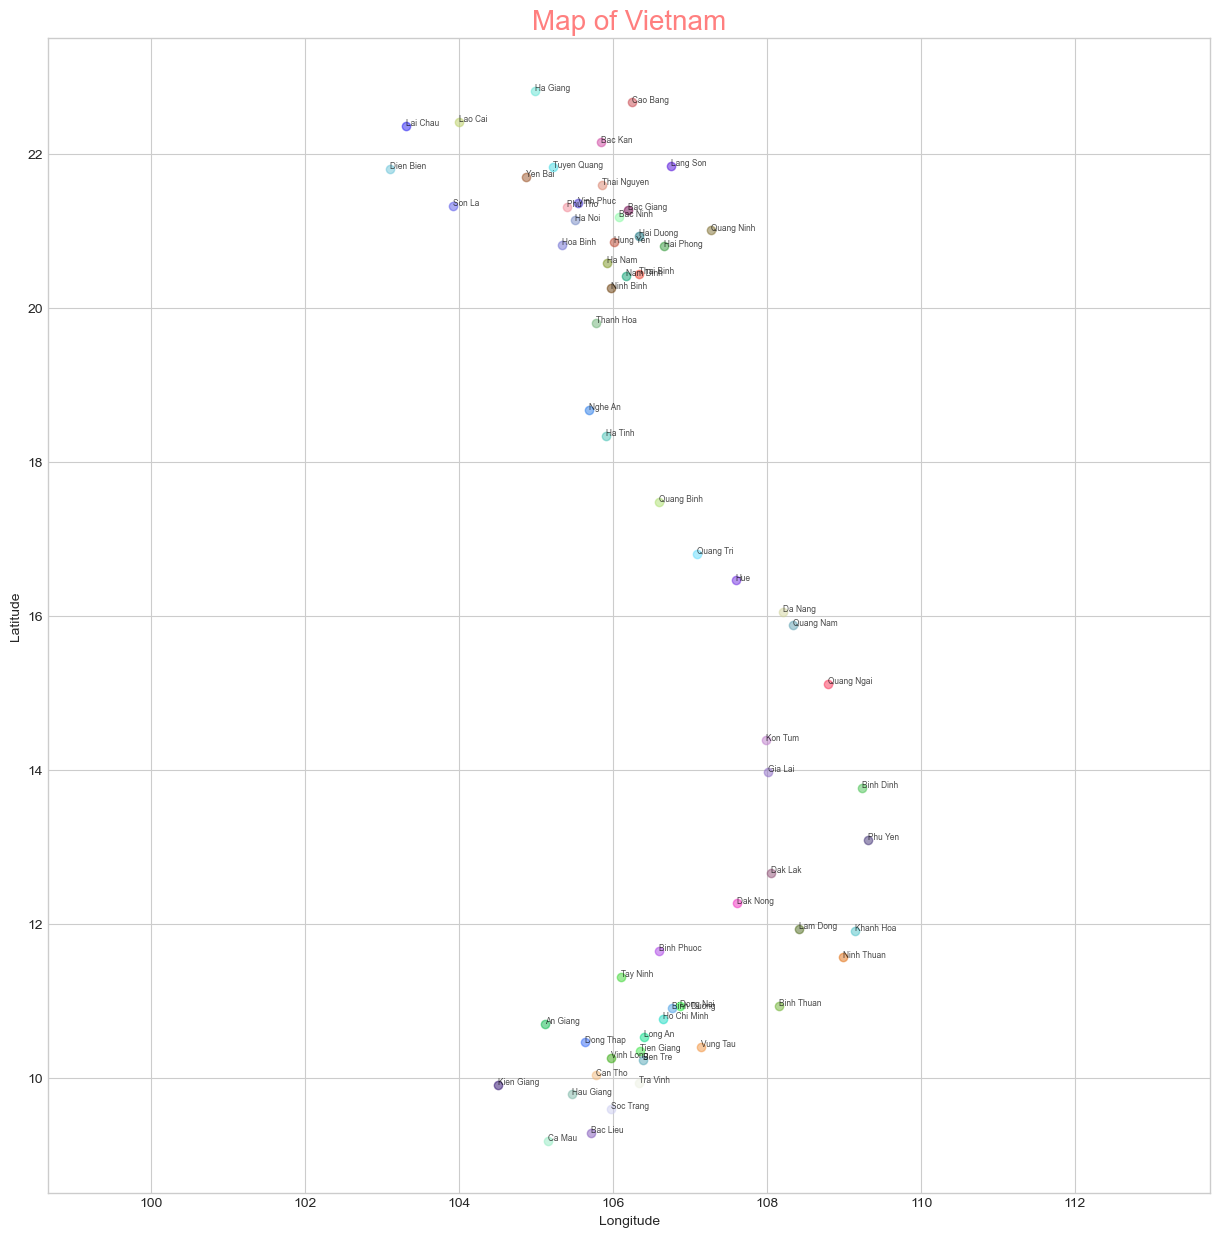

In [5]:
# Visualize
Longitude, Latitude, Province = df["Longitude"],df["Latitude"],df["Province"]

# change style plt
plt.style.available
plt.style.use('seaborn-whitegrid')

# size fig
plt.figure(figsize = (15,15))

# scatter
# plt.scatter(Longitude,Latitude, c = color, alpha = 0.4)

for x, y in zip(Longitude, Latitude):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, c=[rgb], alpha = 0.5)

plt.axis([100,112,8,30])
plt.axis("equal")

# label
plt.title("Map of Vietnam", color = "red",fontsize = 20, alpha = 0.5)
plt.xlabel("Longitude", fontsize = 10)
plt.ylabel("Latitude", fontsize = 10)

for i in range(len(Province)):
    plt.text(Longitude[i],Latitude[i],Province[i],color = "black", fontsize = 6,alpha = 0.7)
# show
plt.show();

## 1.6. I/O

In [6]:
# Create START & END
start = str(input("START: ")).strip().title()
end = str(input("END: ")).strip().title()

# Time Clock 
start_time = time.time()

# Create id for START & END 
for i in range(len(df)):
    if df.iloc[i,0] == start:
        start_id = i
    elif df.iloc[i,0] == end:
        end_id = i

print("{} has ID {}.".format(start,start_id))
print("{} has ID {}.".format(end,end_id))

Thanh Hoa has ID 10.
Ho Chi Minh has ID 0.


# 2. A* algorithm

## 2.1. Declare Node object

In [ ]:
class node():
    def __init__(self, name = None, par = None, h=0, g=0, w=0):
        self.name = name
        self.h = h     # h(x) of each node saved at the end of the list in the data set, distance from current node to goal node
        self.g = g     # g(x): distance from start node to current node
        self.par = par # parent of current node, used to tracking path to goal
        self.w = w     # distance from current node to it's parent
        
    # "less than": used to compare the node's f(x) function 
    # to add to the PriorityQueue in order of priority, the smaller f(x) will be added first
    def __lt__(self,other): 
        if other == None:
            return False
        else:
            return self.h + self.g < other.h + other.g  # A_Star algorithm: f(x) = h(x) + g(x)
    def __eq__(self,other):
        if other == None:
            return False
        else:
            return self.name == other.name   

    # Find parent of trace path to goal
    def parent(self, distance, last_h): 
        print(self.name, end = " <- ")
        distance += self.w
        if self.par != None: # other nodes except start warehouse
            return self.par.parent(distance, last_h)
        else: # this is the start warehouse, it doesn't have parent node 
            print("\nTotal distance: {}(km)".format(distance + last_h))

## 2.2. A* algorithm

**PriorityQueue** is a queue that add element in order of priority, that means in this algorithm, the smaller node (smaller f(x)) will added first.

E.g.: [3,6,9] are the f(x) function of 3 nodes, if we add 2 nodes with f(x) are 4 and 8, the PriorityQueue will become [3,4,6,8,9]

**Step 1**: Initial open, closed are PriorityQueue
* `Open queue` contains unexpanded nodes
* `Closed queue` contains expanded nodes
  
**Step 2**: Expand nodes in `open queue`, if child node not in `open queue` and not in `closed queue` 

-> Add to `open queue` and expand later (in this program, we call expanding node is expand_node)

**Step 3**: If we find out goal node, break the program and print solution
* If not, return to step 2
* If `open queue` is empty and we haven't found goal node ==> Error, can't find solution !

In [ ]:
# A_Star function
def AStar(S = node(start), G = node(end)):
    # initial open queue and closed queue
    open = PriorityQueue()
    closed = PriorityQueue()

    # add attribute S (node_start) to open queue to start expand
    S.h = data[S.name][-1]  # h(x):
    S.g = 0                 # g(x)
    open.put(S)             # put to Priority Queue
    
    # while loop for check all city 
    while True:
        if open.empty():
            print("Can't solve!")
            break
        else:
            expand_node = open.get(0)        # take out each element in the open queue by index and expand it; after open  close now 
            closed.put(expand_node)          # put expanded nodes to closed, so that these nodes are not expanded again
            expand_node.h = data[expand_node.name][-1]
            print('Scan', expand_node.name, expand_node.h, expand_node.g)

            # Finding Solution
            if expand_node.name == G.name:   #goal 
                print('SOLVE SUCCESSFULLY!\n\nPath to goal city:', end =" ")
                last = data[G.name][-1]
                expand_node.parent(distance = 0,last_h = last)          # print path after solving
                break
            else:
                # scan others node, browse all elements of node O
                for i in range (0, len(data[expand_node.name])-1, 2):    
                    tmp = node(data[expand_node.name][i])
                    tmp.h = data[tmp.name][-1]                          # h(x)
                    tmp.g = expand_node.g + data[expand_node.name][i+1] # g(x)      
                    tmp.par = expand_node                               # name of parent
                    tmp.w = data[expand_node.name][i+1]                 # distance current node to parent
                    
                    if tmp not in open.queue and tmp not in closed.queue: 
                        open.put(tmp)                                   # put new node to queue

# Run algorithm 
AStar()


open = PriorityQueue()
    closed = PriorityQueue()

    # add attribute S (node_start) to open queue to start expand
    S.h = data[S.name][-1]  # h(x):
    S.g = 0                 # g(x)
    open.put(S)             # put to Priority Queue
    
    # while loop for check all city 
    while True:
        if open.empty():
            print("Can't solve!")
            break
        else:
            expand_node = open.get(0)        # take out each element in the open queue by index and expand it; after open  close now 
            closed.put(expand_node)          # put expanded nodes to closed, so that these nodes are not expanded again
            expand_node.h = data[expand_node.name][-1]
            lat_check.append(lat[expand_node.name])  #thêm vào node đã đi qua để visualize ở phần sau
            long_check.append(long[expand_node.name]) #thêm vào node đã đi qua để visualize ở phần sau
            #print('Scan', expand_node.name, expand_node.h, expand_node.g)
